# Практическая работа по лекциям 10 и 11
## Поймай меня, если сможешь
## Преамбула
Будем решать `задачу идентификации злоумышленника` по его поведению в сети Интернет. Если коротко, то он будет вести себя совсем не так, как обычный человек. Если это взломщик почтовых ящиков, то, скорее всего, в отличие от владельца ящика, он будет ставить флажки на письмах по-другому, иначе перемещать курсор мышки, удалять или отправлять письма с нетипичной для владельца тематикой.

В нашем случае необходимо решить похожую задачу: алгоритм будет анализировать `последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком`, и определять, владелец это или злоумышленник (кто-то другой).


### Данные
- `practice_anomaly_data.csv` $-$ таблица с данными о сессиях пользователей. Данные были собраны с прокси-серверов Университета Блеза Паскаля. 
- `site.pkl` $-$ словарь с сайтами.

Изначально данные были размечены, но я удалил столбец с метками, чтобы можно было решить задачу поиска аномалий `методами обучения без учителя`. 

### Признаки пользователей
- Признаки, названия которых начинаются с `site`, это номера сайтов, которые посетил пользователь в конкретную сессию. По номеру сайта можно найти ссылку в файле `site.pkl`;
- Признаки, названия которых начинаются с `time`, являются временными метками, когда пользователь посетил сайт.
- Допустимо ожидаемый процент аномалий меньше 1% (примерно 0.9%)

## Ход работы
### 1. Загрузка данных
1. Загрузите данные из файла `practice_anomaly_data.csv`, используя атрибут `session_id` в качестве индекса.

In [15]:
import pandas as pd

df = pd.read_csv('practice_anomaly_data.csv', index_col="session_id")


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 253561 entries, 1 to 253561
Data columns (total 20 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   site1   253561 non-null  int64  
 1   time1   253561 non-null  object 
 2   site2   250098 non-null  float64
 3   time2   250098 non-null  object 
 4   site3   246919 non-null  float64
 5   time3   246919 non-null  object 
 6   site4   244321 non-null  float64
 7   time4   244321 non-null  object 
 8   site5   241829 non-null  float64
 9   time5   241829 non-null  object 
 10  site6   239495 non-null  float64
 11  time6   239495 non-null  object 
 12  site7   237297 non-null  float64
 13  time7   237297 non-null  object 
 14  site8   235224 non-null  float64
 15  time8   235224 non-null  object 
 16  site9   233084 non-null  float64
 17  time9   233084 non-null  object 
 18  site10  231052 non-null  float64
 19  time10  231052 non-null  object 
dtypes: float64(9), int64(1), object(10)
memory usage: 40.

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
site1,253561.0,3243.550144,7247.006212,1.0,53.0,677.0,1980.0,41601.0
site2,250098.0,3272.400883,7307.480404,1.0,53.0,677.0,1980.0,41600.0
site3,246919.0,3303.987757,7347.809918,1.0,53.0,677.0,1986.5,41599.0
site4,244321.0,3325.109422,7371.245606,1.0,52.0,677.0,1995.0,41599.0
site5,241829.0,3343.406035,7379.758550,1.0,52.0,678.0,2054.0,41599.0
site6,239495.0,3352.312637,7380.413775,1.0,52.0,679.0,2077.0,41600.0
site7,237297.0,3395.546771,7435.727671,1.0,55.0,679.0,2197.0,41600.0
site8,235224.0,3430.157765,7473.417900,1.0,55.0,704.0,2287.0,41601.0
site9,233084.0,3438.400088,7471.062652,1.0,55.0,733.0,2366.0,41601.0
site10,231052.0,3460.388861,7492.447548,1.0,55.0,733.0,2403.0,41601.0


In [18]:
df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,3846.0,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,39.0,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,782.0,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,178.0,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11


2. Используя модуль `pickle`* языка программирования `python`, загрузите содержимое словаря с сайтами из файла `site.pkl`.

*Краткое описание модуля <a href=https://pythonworld.ru/moduli/modul-pickle.html>здесь</a>

In [19]:
import pickle

with open('site.pkl', 'rb') as f:
    site = pickle.load(f)

### 2. Предобработка данных
В данных имеются проблемы. Разделите набор признаков на два поднабора: по времени посещения и по сайтам, которые посещали пользователи.
1. Заполните пропущенные номера сайтов;
2. Проверьте типы данных у атрибутов обеих таблиц. Все временные признаки приведите к типу `datetime` с помощью метода `pd.to_datetime`.

Обратите внимание, что пропуски нужно `заполнять осторожно и обдуманно`, потому что вы можете внести лишние зависимости, которые впоследствии будут мешать корректно идентифицировать аномальных пользователей.

```
Пропуски в столбцах указывают на то, что пользователь не посещал определенные сайты в указанные временные промежутки. 
Использование метода ffill (заполнение вперед) позволяет предположить, что если пользователь посетил сайт в предыдущий раз, он мог продолжать его посещать в последующих временных точках. 

А так-же метод forward fill сохраняет структуру данных и позволяет избежать добавления новых значений, которые не имеют оснований. 
```

In [20]:
site_features = df.filter(like='site')
time_features = df.filter(like='time')

In [21]:
filled_sites = site_features.ffill()

In [22]:
# Проверяем типы данных до преобразования
types_before = df.dtypes
print(types_before)

site1       int64
time1      object
site2     float64
time2      object
site3     float64
time3      object
site4     float64
time4      object
site5     float64
time5      object
site6     float64
time6      object
site7     float64
time7      object
site8     float64
time8      object
site9     float64
time9      object
site10    float64
time10     object
dtype: object


In [23]:
# Приводим все временные столбцы к типу datetime
for column in df.columns:
    if 'time' in column:
        df[column] = pd.to_datetime(df[column], errors='coerce')

In [24]:
# Проверяем типы данных после преобразования
types_after = df.dtypes
print(types_after)

site1              int64
time1     datetime64[ns]
site2            float64
time2     datetime64[ns]
site3            float64
time3     datetime64[ns]
site4            float64
time4     datetime64[ns]
site5            float64
time5     datetime64[ns]
site6            float64
time6     datetime64[ns]
site7            float64
time7     datetime64[ns]
site8            float64
time8     datetime64[ns]
site9            float64
time9     datetime64[ns]
site10           float64
time10    datetime64[ns]
dtype: object


### 3. Кластеризация данных 
Поскольку в полученных данных нет меток, определяющих явно пользователя как обычного/аномального, нужно сформировать представление о данных. Необходимо произвести кластеризацию и посмотреть, какие метки и каким пользователям выдаёт алгоритм. Для этого:
1. Обучите* на предобработанных данных алгоритм кластеризации `k-means` и получите метки кластеров. Известно ли в этом кейсе, сколько кластеров требуется для решения задачи? `Прокомментируйте`.

*Перед кластеризацией временные признаки переведите в число и разделите на $10^9$, а затем прошкалируйте. Но при этом временные метки не удаляйте, а отложите в сторону для дальнейших действий.

In [25]:
from sklearn.preprocessing import StandardScaler


# Преобразование временных меток в числовой формат
time_columns = df.filter(like='time').columns
time_data = df[time_columns].copy()
for column in time_columns:
    df[column] = pd.to_datetime(df[column]).astype(int) / 10**9

In [26]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
site_data = df.drop(columns=time_columns)
# Заполняем пропуски в данных с сайтами
site_data_imputed = imputer.fit_transform(site_data)

In [27]:
# Масштабируем данные
scaler = StandardScaler()
scaled_data = scaler.fit_transform(site_data_imputed)

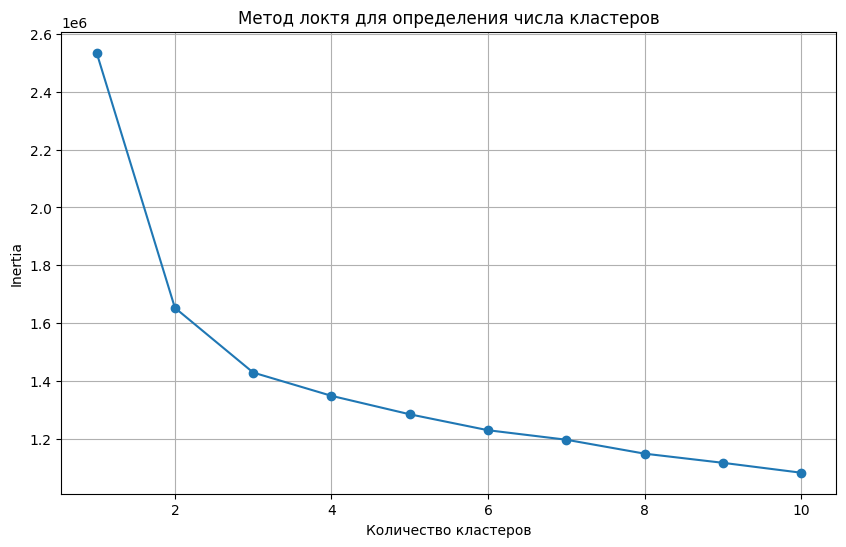

In [28]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.title('Метод локтя для определения числа кластеров')
plt.grid()
plt.show()

In [29]:
optimal_k = 3  # Замените на выбранное значение на основе метода локтя
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_data)

```Количество кластеров заранее неизвестно, поэтому мы используем метод локтя для его определения.```

2. Обучите на предобработанных данных алгоритм кластеризации по плотности DBSCAN. Получите метки классов и сохраните в отдельный столбец данных.

In [30]:
# ваш код здесь

3. Пока достаточно трудно проанализировать результаты двух кластеризаций. У нас есть временные метки, которые могут помочь проанализировать результаты кластеризации. Воспользуйтесь методом конструирования признаков и добавьте в набор следующие фичи:
   * час, когда пользователь зашёл на сайт;
   * день недели, когда пользователь зашёл на сайт;
   * бинарный признак, указывающий, что день был выходным днём;
   * посчитать длительность сессии (разница времени между `site10` и `site1`);
   * признак, сообщающий, первая или вторая половина часа, когда пользователь зашёл на сайт;
   * придумать свои дополнительные признаки.

In [31]:
# ваш код здесь

4. Придумайте, как с помощью сконструированных признаков можно визуализировать разницу между кластерами. 

In [32]:
# ваш код здесь

5. Обучите алгоритмы кластеризации, но уже с добавлением полученных признаков. Снова постройте визуализации из пункта 4. `Внесли ли новые фичи изменения в результат кластеризации?`

## 4. Конструирование признаков (feature engineering)
Полученных признаков мало, можно ещё добавить фичей. Например:
1. попробуйте создать такой признак, который будет представлять собой число вида `ГГГГММ` от той даты, когда проходила сессия. Например, 201407 - 2014 год и 7 месяц. Таким образом, мы будем учитывать помесячный линейный тренд за весь период предоставленных данных;
2. попробуйте намайнить признаки на основе словаря с сайтами: сформируйте `"мешок" сайтов`*. То есть необходимо создать новую матрицу, в которой строкам будут соответствовать сессии из 10 сайтов, а столбцам – индексы сайтов. На пересечении строки и столбца будет стоять число – количество раз, которое встретился сайт в сессии номер N. 

*Не используйте для второго задания `pandas` и `numpy`! Полученная матрица просто не влезет в память вашего компьютера. Вместо этого используйте класс <a href=https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html>CountVectorizer</a> для создания матрицы.

In [33]:
# ваш код здесь

In [34]:
# и можно ещё здесь

In [35]:
# подсказка
# CountVectorizer принимает на вход множество текстов,
# поэтому вам необходимо последовательности индексов сайтов для одной сессии
# склеить в строки
# код ниже поможет
def row_to_text(row):
    return ' '.join(map(str, row))
# функцию необходимо применить к каждой строке таблицы с последовательностями индексов

## Поиск аномальных пользователей

На этом этапе у нас должны быть две матрицы: исходные признаки+новые фичи и матрица от CountVectorizer'a. 
1. Склейте две матрицы по вертикали;
2. Произведите кластеризацию методами `k-means` и `dbscan` на обобщённых данных. Сохраните результаты кластеризации в отдельный датафрейм, в котором метки классов расставлены в соответствии с наблюдениями в исходных данных;

In [36]:
# ваш код здесь

3. Полученный набор данных многомерен. (`Сколько столбцов в полученной матрице?`) Однако хотелось бы визуализировать множество пользователей и попробовать разделить их на чёткие кластеры визуально. Посмотрите метод для понижения размерности, который называется методом стохастически вложенных соседей (<a href=https://nuancesprog.ru/p/14951/>t-SNE</a>) и примените его к вашим данным. Визуализируйте результат. `Видны ли чёткие границы кластеров?` 

In [37]:
# ваш код здесь

4. Попробуйте использовать модельные методы. Возьмите для начала метод опорных векторов с одним классом `One-Class SVM`. Установите параметр `kernel='linear` и сгенерируйте метки классов. Это позволит модели предполагать, что данные линейно разделимы. Поможет ли это предположение модели в идентификации аномального пользователя? Затем установите параметр `kernel='poly'`, что позволит создать модель, учитывающую нелинейные зависимости. Сгенерируйте метки классов. Пользуйтесь документацией библиотеки `scikit-learn`: [OneClassSVM - документация](https://scikit-learn.org/dev/modules/generated/sklearn.svm.OneClassSVM.html)

In [38]:
# ваш код здесь

5. После этого используйте более сложную модель изолирующего леса ([`Isolation Forest`](https://scikit-learn.ru/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest)). По своей работе он модель похожа на случайный лес, однако при этом стремится с помощью неглубоких деревьев отделить самые аномальные наблюдения от всей выборки. Подберите гиперпараметры модели вручную, сгенерируйте метки и сохраните их.

In [39]:
# ваш код здесь

6. Проанализируйте полученные результаты работы модели. Используя визуализации в данных и допустимо ожидаемый процент аномалий, попытайтесь определить, какая модель справилась лучше. Сделайте выводы.

In [40]:
# ваш код здесь

7. Сохраните метки лучшей модели в файл csv (только колонку с ответами модели!) и отправьте вместе с этим отчётом мне в телегу.